In [1]:
import numpy as np, pandas as pd
import sympy as sym
from sympy import symbols, Matrix, solve, simplify

In [2]:
from db_queries import get_outputs as go, get_ids
from vivarium import Artifact
!whoami
!date

nicoly
Mon Aug 23 20:31:59 PDT 2021


## INITIALIZE VARS

In [3]:
## SOLVE EQNS
s4, i3 = symbols('s4 i3')
r4, s3, i2 = symbols('r4 s3 i2')
r3, s2, i1 = symbols('r3 s2 i1')
r2, s1 = symbols('r2 s1')
d4, d3, d2, d1 = symbols('d4 d3 d2 d1')
f4, f3, f2, f1 = symbols('f4 f3 f2 f1')
t1, t2 = symbols('t1 t2')

ap4, ap3, ap2, ap1, ap0 = symbols('ap4 ap3 ap2 ap1 ap0')

acmr = sym.Symbol('acmr')

dur_cat1, dur_cat2, dur_cat3, dur_cat4 = symbols('dur_cat1 dur_cat2 dur_cat3 dur_cat4')

## SETTINGS

In [4]:
age_group = 4 #post neonatal
sex = 2 #female

In [5]:
# these are ordered such that first n (n=9 for now) are the vars we want sympy to solve in terms of the remaining vars

# unknowns = [s1,s2,s3,s4,t1,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4]
unknowns = [i2,s1,s2,s3,s4,r3,i1,i3,t1,r4,r2,d1,d2,d3,d4,f1,f2,f3,f4]

## LOAD FNS & VALUES

In [6]:
def build_matrix(eqns, unknowns):
    """
    INPUT
    ----
    eqns: a list of equations. These are of the form:
          [{x_i:a, x_j:b}, y] for the equation:
          ax_i + bx_j = y
    unknowns: a list of sympy unknowns
    ----
    OUTPUT
    ----
    A:  a matrix containing the coefficients of LHS of all eq in eqns.
        - nrows = number of equations
        - rcols = number of unknowns
    b: an nx1 matrix containing the RHS of all the eqns
    x: a sympy matrix of the unknowns
    
    Note that Ax = b
    """
    n_eqns = len(eqns)
    n_unknowns = len(unknowns)

    # frame for matrix/LHS equation coefficients.
    # nrows = n_eqns, ncols = n_unknowns
    A = pd.DataFrame(
        index = range(n_eqns),
        columns = unknowns,
        data = np.zeros([n_eqns,n_unknowns])
    )

    # frame for RHS of equations
    b = pd.DataFrame(index = range(n_eqns), columns = ['val'])
    
    # define helper fn
    def add_eq(terms, y, i):
        """
        INPUT
        ----
        To input i^(th) equation y = ax_i + bx_j, add_eq wants:
            - terms = {x_i:a, x_j:b}
            - y = y
            - i
        ----
        FUNCTION
        ----
        - Adds coefficients to matrix A.
        - Adds y to row i of vector b
        ----
        EXAMPLE
        ----
        For y = ax_i + bx_j:
        - adds "a" to column "x_i" row i of A
        - adds "b" to column "x_j" row i of A
        - adds "y" to row i of b
        """
        for x in terms.keys():
            A[x][i] = terms[x]
        b.iloc[i] = y

    # populate LHS/RHS
    i = 0
    for eq in eqns:
        add_eq(terms=eq[0], y=eq[1], i=i)
        i += 1

    # convert to sympy matrices
    A = sym.Matrix(A)
    b = sym.Matrix(b)
    x = sym.Matrix(unknowns) #vars to solve for

    return A, x, b

In [7]:
# RUN SCRIPTS
from set_background_vals import *

d1_val, d2_val, d3_val, d4_val = [1-np.exp(-1*i/365) for i in set_ds(sex_id = sex, age_group_id = age_group)]
f1_val, f2_val, f3_val, f4_val = set_fs(sex_id = sex, age_group_id = age_group)

## TODO: is this the correct time_step?
ap0_val, ap1_val, ap2_val, ap3_val, ap4_val = set_ps(sex_id = sex, age_group_id = age_group, time_step = 1)

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/ihme/homes/nicoly/vivarium_research_ciff_sam/wasting_transitions/set_background_vals.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasting_exp['sex_id'] = np.where(wasting_exp['sex'] == 'Male', 1, 2)
/ihme/homes/nicoly/vivarium_research_ciff_sam/wasting_transitions/set_background_vals.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

## BUILD & SOLVE SYSTEM OF EQNS

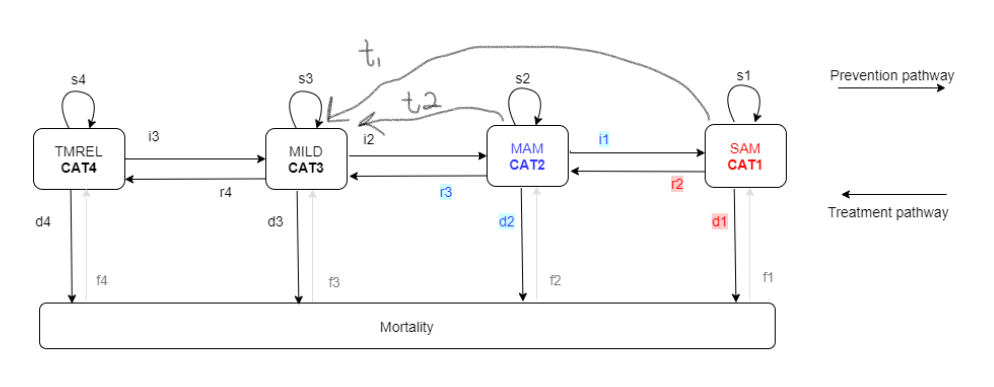

In [8]:
# # assuming equilibrium:
# p4*s4 + p3*r4 + p0*f4 = p4
eq1 = [{s4:ap4, r4:ap3, f4:ap0}, ap4]

# p4*i3 + p3*s3 + p2*r3 + p0*f3 = p3
eq2 = [{i3:ap4, s3:ap3, r3:ap2, t1:ap1, f3:ap0}, ap3]

# p3*i2 + p2*s2 + p1*r2 + p0*f2 = p2
eq3 = [{i2:ap3, s2:ap2, r2:ap1, f2:ap0}, ap2]

# p2*i1 + p1*s1 + p0*f1 = p1
eq4 = [{i1:ap2, s1:ap1, f1:ap0}, ap1]

# p4*d4 + p3*d3 + p2*d2 + p1*d1 + p0*0 = p0
eq5 = [{d4:ap4, d3:ap3, d2:ap2, d1:ap1}, ap0]


# # rows sum to one:
# s4 + i3 + d4 = 1
eq6 = [{s4:1, i3:1, d4:1}, 1]

# r4 + s3 + i2 + d3 = 1
eq7 = [{r4:1, s3:1, i2:1, d3:1}, 1]

# r3 + s2 + i1 + d2 = 1
eq8 = [{r3:1, s2:1, i1:1, d2:1}, 1]

# r2 + s1 + d1 = 1
eq9 = [{r2:1, t1:1, s1:1, d1:1}, 1]

# f4 + f3 + f2 + f1 + sld = 1
eq10 = [{f4:1, f3:1, f2:1, f1:1}, 1]


# try again: add duration from isanaka
eq11 = [{t1:1, r2:1, d1:1}, 1/dur_cat1]



# # # adding durations of states
# # r2 + d1 = 1/Dsam
# eq11 = [{r2:1, d1:1, t1:1}, (1/dur_cat1)]

# # r3 + i1 + d2 = 1/Dmam
# eq12 = [{r3:1, i1:1, d2:1}, (1/dur_cat2)]

# # r4 + i2 + d3 = 1/Dmild
# eq13 = [{r4:1, i2:1, d3:1}, 1/dur_cat3]

# # i3 + d4 = 1/Dtmrel
# eq14 = [{i3:1, d4:1}, 1/dur_cat4]

# # new_equation = [{var_a:coef_a},rhs]

# ## extras
# # r3/7.14 = i1
# eq15 = [{r3:(1/7)}, i1]

# eq16 = [{i3:1}, 0]
# eq17 = [{r4:1}, 0]

In [9]:
all_eqns = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10]#,eq11]#,eq15]#,eq15]#,eq11,eq12,eq13,eq14]

A1, x1, b1 = build_matrix(all_eqns, unknowns)

result = sym.solve(A1 * x1 - b1, x1)

/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/share/code/nicoly/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## CHECKOUT WHAT WE WERE SOLVING

In [10]:
len(all_eqns)

10

In [11]:
# matrix we're solving
pd.DataFrame(np.array(A1), columns = unknowns, index = [f'eq{i}' for i in range(1,len(all_eqns)+1)])

,i2,s1,s2,s3,s4,r3,i1,i3,t1,r4,r2,d1,d2,d3,d4,f1,f2,f3,f4
eq1,0.0,0.0,0.0,0.0,ap4,0.0,0.0,0.0,0.0,ap3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ap0
eq2,0.0,0.0,0.0,ap3,0.0,ap2,0.0,ap4,ap1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ap0,0.0
eq3,ap3,0.0,ap2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ap1,0.0,0.0,0.0,0.0,0.0,ap0,0.0,0.0
eq4,0.0,ap1,0.0,0.0,0.0,0.0,ap2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ap0,0.0,0.0,0.0
eq5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ap1,ap2,ap3,ap4,0.0,0.0,0.0,0.0
eq6,0.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
eq7,1,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
eq8,0.0,0.0,1,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
eq9,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eq10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [12]:
# equals
np.array(x1)

array([[i2],
       [s1],
       [s2],
       [s3],
       [s4],
       [r3],
       [i1],
       [i3],
       [t1],
       [r4],
       [r2],
       [d1],
       [d2],
       [d3],
       [d4],
       [f1],
       [f2],
       [f3],
       [f4]], dtype=object)

In [13]:
unknowns

[i2, s1, s2, s3, s4, r3, i1, i3, t1, r4, r2, d1, d2, d3, d4, f1, f2, f3, f4]

In [14]:
# solution to our system of eqns
result

{i2: ap0*f3/ap3 + ap0*f4/ap3 + ap1*t1/ap3 + ap2*r3/ap3 - d3 - ap4*d4/ap3,
 s1: -r2 - t1 + ap2*d2/ap1 + ap3*d3/ap1 + ap4*d4/ap1 + (-ap0 + ap1)/ap1,
 s2: -ap0*f2/ap2 - ap0*f3/ap2 - ap0*f4/ap2 - ap1*r2/ap2 - ap1*t1/ap2 - r3 + 1 + ap3*d3/ap2 + ap4*d4/ap2,
 s3: -ap0*f3/ap3 - ap0*f4/ap3 - ap1*t1/ap3 - ap2*r3/ap3 - r4 + 1 + ap4*d4/ap3,
 s4: -ap0*f4/ap4 - ap3*r4/ap4 + 1,
 i1: ap0*f2/ap2 + ap0*f3/ap2 + ap0*f4/ap2 + ap1*r2/ap2 + ap1*t1/ap2 - d2 - ap3*d3/ap2 - ap4*d4/ap2,
 i3: ap0*f4/ap4 + ap3*r4/ap4 - d4,
 d1: ap0/ap1 - ap2*d2/ap1 - ap3*d3/ap1 - ap4*d4/ap1,
 f1: -f2 - f3 - f4 + 1}

In [15]:
# this is the dictionary of values we want to plug into our variables
subs = {
    s1: s1,
    s2: s2,
    s3: s3,
    s4: s4,
    r2: r2, #1/59,
    r3: r3, #1/52, #this is actually r3 + t2
    r4: r4, #0.05, #assumed almost 0
    i1: i1, #0.0007, #james et al
    i2: i2, #0.00708,
    i3: i3, #0.014, #assumed almost 0
    t1: t1, #1/48,#(1.5/365)*.43*.7, #
    d1: d1_val,
    d2: d2_val,
    d3: d3_val,
    d4: d4_val,
    f1: f1_val,
    f2: f2_val,
    f3: f3_val,
    f4: f4_val,
    ap0: ap0_val,
    ap1: ap1_val,
    ap2: ap2_val,
    ap3: ap4_val,
    ap4: ap4_val
}

In [16]:
def solution_set(more_subs = {}):
    df = pd.DataFrame({
        'var':result.keys(),
        'val':[result[i].subs(subs).subs(more_subs) for i in result.keys()]
    })
    return df

In [17]:
solution_set()

,var,val
0,i2,0.115526176934477*r3 + 0.0331932645084267*t1 +...
1,s1,-r2 - t1 + 0.999674927533161
2,s2,-0.287322452704834*r2 - r3 - 0.287322452704834...
3,s3,-0.115526176934477*r3 - r4 - 0.033193264508426...
4,s4,0.999965196472842 - 1.0*r4
5,i1,0.287322452704834*r2 + 0.287322452704834*t1 + ...
6,i3,1.0*r4 + 2.22737008540041e-5
7,d1,0.000325072466838689
8,f1,0.0231004389169458


In [18]:
solution_set({r3:(0.512/63) + (.488/41.3), t1:.488/48.3, r2:.512/50.5})

,var,val
0,i2,0.00265041578875304
1,s1,0.979432794003038
2,s2,0.974110021830502
3,s3,0.997328392956002 - r4
4,s4,0.999965196472842 - 1.0*r4
5,i1,0.00589942023754690
6,i3,1.0*r4 + 2.22737008540041e-5
7,d1,0.000325072466838689
8,f1,0.0231004389169458


In [19]:
solution_set({r3:(0.512/63) + (.488/41.3), t1:.488/48.3, r2:.512/50.5, r4:.001})

,var,val
0,i2,0.00265041578875304
1,s1,0.979432794003038
2,s2,0.974110021830502
3,s3,0.996328392956002
4,s4,0.998965196472842
5,i1,0.00589942023754690
6,i3,0.00102227370085400
7,d1,0.000325072466838689
8,f1,0.0231004389169458


In [20]:
f1_val

0.02310043891694573

In [21]:
d1_val

0.00014482773410817718

In [22]:
def toggle_solution_set(r3_val, t1_val, r2_val, r4_val):
    print(solution_set({r3:r3_val, t1:t1_val, r2:r2_val, r4:r4_val}))

In [23]:
toggle_solution_set(r3_val = 1/52, t1_val = 1/48, r2_val = 1/59, r4_val = .001)

  var                   val
0  i2   0.00292429610552781
1  s1     0.961892441657455
2  s2     0.969782480299017
3  s3     0.996054512639228
4  s4     0.998965196472842
5  i1    0.0109391572947868
6  i3   0.00102227370085400
7  d1  0.000325072466838689
8  f1    0.0231004389169458


In [24]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [25]:
y = interactive(toggle_solution_set,
                r3_val = (1/80,1/30,0.00208), t1_val = (1/80,1/30,0.00208),
                r2_val = (1/80,1/30,0.00208), r4_val = (.0001,.01,0.00099),
                readout_format='.9f'
               )

In [1]:
# huh need to fix slider display precision
display(y)

NameError: name 'y' is not defined